# Hello and welcome!
Here is a link to the Kaggle for convenience: https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview

Here is a link to the data: https://drive.google.com/drive/folders/1TgD14QwrcnvYTQKxg2xDVbDUdWAg_G3T?usp=sharing

Feature information can be found either in the `feature_info.md` file, or at the following link: https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/data

# EDA
Let's get better acquainted with our dataset.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/CPSC540')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

In [4]:
def print_df_missing_values(df: pd.DataFrame):
    has_missing_value_col = df.isna().any()
    has_missing_value = has_missing_value_col.any()

    if not has_missing_value:
        print('No missing values')
    else:
        for i, col_has_missing_value in enumerate(has_missing_value_col):
            if col_has_missing_value:
                col_name = has_missing_value_col.index[i]

                n_missing = df[col_name].isna().sum()
                total = df[col_name].shape[0]

                print(f'(# Missing {col_name} / total): {n_missing}/{total}')

def print_df_info(df: pd.DataFrame):
    print(f'size: {df.shape}')
    print(f'Features:\n{df.dtypes}')
    print_df_missing_values(df)

Our data is time sensitive:
<ul>
    <li>
        Client data: Up to 2 days before prediction date.
    </li>
    <li>
        Gas/Electricity prices: Up to 2 days before prediction date.
    </li>
    <li>
        Weather Forecast: Updates at midnight. We can use same day data for this feature.
    </li>
</ul>

Suggestion: Create lag features for our samples to get Gas/Electricity price from 2 days ago?

Our data is split into several different files. We will have to merge them for training.

We have missing target values... We should impute these rows.

In [5]:
PRODUCT_TYPE_MAP = {
    0: 'Combined',
    1: 'Fixed',
    2: 'General service',
    3: 'Spot',
}

In [6]:
train_df = pd.read_csv('train.csv')
print_df_info(train_df)
train_df.head(4)

size: (2018352, 9)
Features:
county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
data_block_id           int64
row_id                  int64
prediction_unit_id      int64
dtype: object
(# Missing target / total): 528/2018352


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1


In [7]:
client_df = pd.read_csv('client.csv')
print_df_info(client_df)
client_df.head(4)

size: (41919, 7)
Features:
product_type            int64
county                  int64
eic_count               int64
installed_capacity    float64
is_business             int64
date                   object
data_block_id           int64
dtype: object
No missing values


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2


In [8]:
forecast_weather_df = pd.read_csv('forecast_weather.csv')

# Drop the last row because it's producing all nans as a result of an uploading error
n_fw_df, d_fw_df = forecast_weather_df.shape
forecast_weather_df.drop(forecast_weather_df.index[n_fw_df - 1], inplace=True)

In [9]:
print_df_info(forecast_weather_df)
forecast_weather_df.head(4)

size: (2714561, 18)
Features:
latitude                             float64
longitude                            float64
origin_datetime                       object
hours_ahead                          float64
temperature                          float64
dewpoint                             float64
cloudcover_high                      float64
cloudcover_low                       float64
cloudcover_mid                       float64
cloudcover_total                     float64
10_metre_u_wind_component            float64
10_metre_v_wind_component            float64
data_block_id                        float64
forecast_datetime                     object
direct_solar_radiation               float64
surface_solar_radiation_downwards    float64
snowfall                             float64
total_precipitation                  float64
dtype: object
(# Missing surface_solar_radiation_downwards / total): 2/2714561


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-08-31 23:00:00+00:00,1.0,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1.0,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-08-31 23:00:00+00:00,1.0,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1.0,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-08-31 23:00:00+00:00,1.0,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1.0,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-08-31 23:00:00+00:00,1.0,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1.0,2021-09-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [10]:
weather_station_to_county_df = pd.read_csv('weather_station_to_county_mapping.csv')
print_df_info(weather_station_to_county_df)
weather_station_to_county_df.head(13)

size: (112, 4)
Features:
county_name     object
longitude      float64
latitude       float64
county         float64
dtype: object
(# Missing county_name / total): 63/112
(# Missing county / total): 63/112


,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
5,NaN,21.7,59.1,NaN
6,NaN,21.7,59.4,NaN
7,NaN,21.7,59.7,NaN
8,NaN,22.2,57.6,NaN
9,NaN,22.2,57.9,NaN


In [11]:
print(pd.value_counts(weather_station_to_county_df['county_name']).head(n=4))
harjumaa_weather_stations = weather_station_to_county_df[weather_station_to_county_df['county_name']=='Harjumaa']
print("\nLongitude range of Harjumaa:", str(max(harjumaa_weather_stations['longitude']) - min(harjumaa_weather_stations['longitude'])))
print("Latitude range of Harjumaa:", str((max(harjumaa_weather_stations['latitude']) - min(harjumaa_weather_stations['latitude']))))

Harjumaa    6
Pärnumaa    5
Võrumaa     5
Saaremaa    4
Name: county_name, dtype: int64

Longitude range of Harjumaa: 1.5
Latitude range of Harjumaa: 0.29999999999999716


We note here that there are multiple weather stations per county, up to 6. For The county with the largest number of weather stations, Harjumaa, these stations span 1.5 degrees longitude and 0.3 degrees longitude, a total distance of about 90km.

# Assembling the feature matrix

Now that we have a sense of what we're working with, let's write functions to turn this into a matrix of relevant features for ML.

First off, we have the date in a datetime format, let's split that off into some categorical variables that capture more information

In [12]:
def split_datetime(df,datetime_col_name="datetime"):
    df[datetime_col_name] = pd.to_datetime(df[datetime_col_name])
    datetime_col = df[datetime_col_name]
    df['day'] = datetime_col.dt.day_of_year
    df['hour'] = datetime_col.dt.hour
    df['day_of_week'] = datetime_col.dt.day_of_week

    # Let's not drop this yet so that we can still quickly confirm that the data maintains
    # temporal ordering at the end. I'll drop this later, right before we start training.
    # df = df.drop(datetime_col_name, axis = 1)

    return df
# We'll probably want to make this one-hot with sklearn.preprocessing.OneHotEncoder, but I think we can leave that to a later step.
# Alternatively, we could think about transforming these features by taking the sin and cos, but I'm feeling like we keep it minimal for now.

Next, let's add the relevant weather forecast to the matrix

As we saw above, we have multiple weather stations per county, but only know the county of each feature. We could try to average the weather forecasts within a county, but for simplicity, let's just take the most central one per county, by longitude.

In [13]:
weather_station_to_county_df_short = weather_station_to_county_df.dropna()

# Subset to just the middle-most
weather_station_to_county_df_short = weather_station_to_county_df_short.groupby('county').apply(lambda x: x.iloc[int((len(x)+1)/2)-1])

# Remove the extra column created by the groupby
weather_station_to_county_df_short = weather_station_to_county_df_short.reset_index(drop = True)

# Add another row for unknown, take Harjumaa, since it's the most populous
unknown_row = weather_station_to_county_df_short.loc[weather_station_to_county_df_short['county_name'] == "Harjumaa"].copy()
unknown_row['county_name'] = "Unknown"
unknown_row['county'] = 12 # Defined by the competition
weather_station_to_county_df_short = pd.concat([weather_station_to_county_df_short,unknown_row])
weather_station_to_county_df_short['county'] = weather_station_to_county_df_short['county'].astype("int64")


weather_station_to_county_df_short

,county_name,longitude,latitude,county
0,Harjumaa,24.7,59.4,0
1,Hiiumaa,22.7,58.8,1
2,Ida-Virumaa,27.2,59.4,2
3,Järvamaa,25.7,58.8,3
4,Jõgevamaa,26.2,58.8,4
5,Lääne-Virumaa,26.2,59.4,5
6,Läänemaa,23.7,58.8,6
7,Pärnumaa,24.7,58.2,7
8,Põlvamaa,27.2,58.2,8
9,Raplamaa,24.7,58.8,9


In [14]:
def add_weather_forecast(df,forecast_df,weather_station_to_county_df_short):

    # Multiply by 1000 and round to int to prevent floating point equality on merge
    forecast_df['longitude'] = np.round(1000 * forecast_df['longitude']).astype('int64')
    forecast_df['latitude'] = np.round(1000 * forecast_df['latitude']).astype('int64')

    weather_station_to_county_df_short['longitude']= np.round(1000 * weather_station_to_county_df_short['longitude']).astype('int64')
    weather_station_to_county_df_short['latitude']= np.round(1000 * weather_station_to_county_df_short['latitude']).astype('int64')

    # Create table with relevant forecasts and county numbers
    weather_forecast_short = pd.merge(forecast_df, weather_station_to_county_df_short, how = 'right', on =['longitude','latitude'])

    weather_forecast_short['forecast_datetime'] = pd.to_datetime(weather_forecast_short['forecast_datetime'], utc = True)

    df['datetime'] = pd.to_datetime(df['datetime'], utc = True)

    # Select only forecasts one day ahead
    weather_forecast_1d = weather_forecast_short[weather_forecast_short['hours_ahead'] <= 24]

    # Merge into the target dataframe
    weather_forecast_1d = weather_forecast_1d.rename(columns = {"forecast_datetime":"datetime"})
    df = pd.merge(df, weather_forecast_1d, how = 'left', on = ['county','datetime'], suffixes = ('','_w'))

    # Remove completely irrelevant/false columns created by merge
    df = df.drop(["latitude", "longitude", "county_name", "data_block_id_w", "origin_datetime", "hours_ahead"], axis = 1)

    return df

In [15]:
test_output = add_weather_forecast(train_df, forecast_weather_df, weather_station_to_county_df_short)

In [16]:
# test_output.iloc[20000:20005,:]
print_df_info(test_output)
test_output.head(5)

size: (2018352, 21)
Features:
county                                             int64
is_business                                        int64
product_type                                       int64
target                                           float64
is_consumption                                     int64
datetime                             datetime64[ns, UTC]
data_block_id                                      int64
row_id                                             int64
prediction_unit_id                                 int64
temperature                                      float64
dewpoint                                         float64
cloudcover_high                                  float64
cloudcover_low                                   float64
cloudcover_mid                                   float64
cloudcover_total                                 float64
10_metre_u_wind_component                        float64
10_metre_v_wind_component                        float64
d

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,temperature,...,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,0,0,12.37478,...,0.191742,0.003571,0.000381,0.194809,2.04143,-3.489926,0.0,0.0,0.0,0.0
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,1,0,12.37478,...,0.191742,0.003571,0.000381,0.194809,2.04143,-3.489926,0.0,0.0,0.0,0.0
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,0,2,1,12.37478,...,0.191742,0.003571,0.000381,0.194809,2.04143,-3.489926,0.0,0.0,0.0,0.0
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,0,3,1,12.37478,...,0.191742,0.003571,0.000381,0.194809,2.04143,-3.489926,0.0,0.0,0.0,0.0
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,0,4,2,12.37478,...,0.191742,0.003571,0.000381,0.194809,2.04143,-3.489926,0.0,0.0,0.0,0.0


Note: We don't have one-day weather forecasts for the last day in the training set, 2023-05-31. This corresponds to the last 3120 entries of the training dataset.

In [17]:
test_output.tail(n=3122)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,temperature,...,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
2015230,15,1,3,0.000,0,2023-05-30 23:00:00+00:00,636,2015230,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015231,15,1,3,200.718,1,2023-05-30 23:00:00+00:00,636,2015231,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015232,0,0,1,2.403,0,2023-05-31 00:00:00+00:00,637,2015232,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015233,0,0,1,516.958,1,2023-05-31 00:00:00+00:00,637,2015233,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015234,0,0,2,0.000,0,2023-05-31 00:00:00+00:00,637,2015234,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00+00:00,637,2018347,64,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00+00:00,637,2018348,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00+00:00,637,2018349,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00+00:00,637,2018350,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def get_client_id(df: pd.DataFrame):
        return df['county'].astype('int').astype('str') + '' + df['is_business'].astype('int').astype('str') + '' + df['product_type'].astype('int').astype('str') + '' + df['data_block_id'].astype('int').astype('str')

def add_client_data(df, client_df):
    # train df and client df merging, we append the client information onto the train rows. IE for the unique county, is_business and product,
    # we add all relevant info from client to rows of train related to that client, also remove county, etc cols
    df['client_id'] = get_client_id(df)
    client_df['client_id'] = get_client_id(client_df)

    # df.drop(columns=['county','is_business','product_type'], inplace=True)
    return_val = pd.merge(df, client_df, on='client_id', how='left') # left so train is the one appended onto

    return_val.drop(columns=['county_y','is_business_y','product_type_y', 'client_id', 'date', 'data_block_id_y'], inplace=True)
    return_val.rename(columns={'county_x': 'county', 'is_business_x': 'is_business', 'data_block_id_x': 'data_block_id', 'product_type_x': 'product_type'}, inplace=True)

    return return_val

In [19]:
print_df_info(add_client_data(train_df, client_df))

size: (2039952, 11)
Features:
county                              int64
is_business                         int64
product_type                        int64
target                            float64
is_consumption                      int64
datetime              datetime64[ns, UTC]
data_block_id                       int64
row_id                              int64
prediction_unit_id                  int64
eic_count                         float64
installed_capacity                float64
dtype: object
(# Missing target / total): 532/2039952
(# Missing eic_count / total): 8352/2039952
(# Missing installed_capacity / total): 8352/2039952


In [20]:
train_df.head(3)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,client_id
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,0,0,0010
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,1,0,0010
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,0,2,1,0020


In [21]:
X = add_weather_forecast(train_df,forecast_weather_df, weather_station_to_county_df_short)
print_df_info(X)
X.tail(n=500)

size: (2018352, 22)
Features:
county                                             int64
is_business                                        int64
product_type                                       int64
target                                           float64
is_consumption                                     int64
datetime                             datetime64[ns, UTC]
data_block_id                                      int64
row_id                                             int64
prediction_unit_id                                 int64
client_id                                         object
temperature                                      float64
dewpoint                                         float64
cloudcover_high                                  float64
cloudcover_low                                   float64
cloudcover_mid                                   float64
cloudcover_total                                 float64
10_metre_u_wind_component                        float64
1

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,client_id,...,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
2017852,2,0,1,6.633,0,2023-05-31 20:00:00+00:00,637,2017852,62,201637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017853,2,0,1,19.319,1,2023-05-31 20:00:00+00:00,637,2017853,62,201637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017854,2,0,3,33.722,0,2023-05-31 20:00:00+00:00,637,2017854,9,203637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017855,2,0,3,41.189,1,2023-05-31 20:00:00+00:00,637,2017855,9,203637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017856,2,1,1,2.004,0,2023-05-31 20:00:00+00:00,637,2017856,65,211637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00+00:00,637,2018347,64,1510637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00+00:00,637,2018348,59,1511637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00+00:00,637,2018349,59,1511637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00+00:00,637,2018350,60,1513637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# first remove the data_block_id == 0, 1 because client_df doesn't have those, so can't train on them
train_df = train_df[train_df['data_block_id'] >= 2] # this makes the train data start at row id of 5856, all data before then is actually garbage

X = add_weather_forecast(train_df, forecast_weather_df, weather_station_to_county_df_short)
X = split_datetime(X)
X = add_client_data(X, client_df)

# Feature Engineering and Data Splitting

In [23]:
features_to_drop = [
    'data_block_id',
    'row_id',
    'prediction_unit_id',
    'cloudcover_total',
    '10_metre_u_wind_component',
    '10_metre_v_wind_component'
  ]

X.drop(columns = features_to_drop, inplace = True)
X.dropna(inplace = True)

In [24]:
print_df_info(X)

size: (1609232, 20)
Features:
county                                             int64
is_business                                        int64
product_type                                       int64
target                                           float64
is_consumption                                     int64
datetime                             datetime64[ns, UTC]
temperature                                      float64
dewpoint                                         float64
cloudcover_high                                  float64
cloudcover_low                                   float64
cloudcover_mid                                   float64
direct_solar_radiation                           float64
surface_solar_radiation_downwards                float64
snowfall                                         float64
total_precipitation                              float64
day                                                int64
hour                                               int64
d

In [25]:
# Separate X and Y into is_consumption true and false, this should actually be done after appending on weather data, I do this so we use a different model for each
X_consumption = X[X['is_consumption'] == 1].copy()
X_production = X[X['is_consumption'] == 0].copy()

X_consumption.drop(columns= 'is_consumption', inplace=True)
X_production.drop(columns ='is_consumption', inplace=True)

# Y_consumption = X_consumption['target'].copy()
# Y_production = X_production['target'].copy()

In [26]:
def get_sin(my_series: pd.Series):
    return np.sin(2 * np.pi * my_series / 24)

def get_cos(my_series: pd.Series):
    return np.cos(2 * np.pi * my_series / 24)

In [27]:
# Wave encode consumption
X_consumption_wave_enc = X_consumption.copy()

X_consumption_wave_enc['hour_sin'] = get_sin(X_consumption_wave_enc['hour'])
X_consumption_wave_enc['hour_cos'] = get_cos(X_consumption_wave_enc['hour'])

X_consumption_wave_enc['day_of_week_sin'] = get_sin(X_consumption_wave_enc['day_of_week'])
X_consumption_wave_enc['day_of_week_cos'] = get_cos(X_consumption_wave_enc['day_of_week'])

X_consumption_wave_enc['day_sin'] = get_sin(X_consumption_wave_enc['day'])
X_consumption_wave_enc['day_cos'] = get_cos(X_consumption_wave_enc['day'])

X_consumption_wave_enc[['day', 'day_sin', 'day_cos', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'hour', 'hour_sin', 'hour_cos']]

,day,day_sin,day_cos,day_of_week,day_of_week_sin,day_of_week_cos,hour,hour_sin,hour_cos
1,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
3,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
5,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
7,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
9,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
1611207,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611209,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611211,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611213,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926


In [28]:
# Wave encode production
X_production_wave_enc = X_production.copy()

X_production_wave_enc['hour_sin'] = get_sin(X_production_wave_enc['hour'])
X_production_wave_enc['hour_cos'] = get_cos(X_production_wave_enc['hour'])

X_production_wave_enc['day_of_week_sin'] = get_sin(X_production_wave_enc['day_of_week'])
X_production_wave_enc['day_of_week_cos'] = get_cos(X_production_wave_enc['day_of_week'])

X_production_wave_enc['day_sin'] = get_sin(X_production_wave_enc['day'])
X_production_wave_enc['day_cos'] = get_cos(X_production_wave_enc['day'])

X_production_wave_enc[['day', 'day_sin', 'day_cos', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'hour', 'hour_sin', 'hour_cos']]

,day,day_sin,day_cos,day_of_week,day_of_week_sin,day_of_week_cos,hour,hour_sin,hour_cos
0,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
2,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
4,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
6,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
8,246,1.0,7.839596e-15,4,0.866025,0.500000,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
1611206,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611208,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611210,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926
1611212,18,-1.0,-1.836970e-16,2,0.500000,0.866025,23,-0.258819,0.965926


In [29]:
# Dropping the columns that we encoded using cosine and sine.
# I'll drop datetime later because I want to use it for splitting the train and test sets.
X_consumption_wave_enc.drop(['hour', 'day_of_week', 'day'], axis=1, inplace=True)
X_production_wave_enc.drop(['hour', 'day_of_week', 'day'], axis=1, inplace=True)

In [30]:
def train_test_split_at_oct_2022(my_df: pd.DataFrame, target_col: str):
    everything_before_oct_2022 = my_df['datetime'] < '2022-10-01'
    X_train = my_df[everything_before_oct_2022]
    X_test = my_df[~everything_before_oct_2022]

    y_train = X_train[target_col]
    y_test = X_test[target_col]

    X_train = X_train.drop(target_col, axis=1)
    X_test = X_test.drop(target_col, axis=1)

    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]

    print(f'Test / Train ratio: {X_test.shape[0]} / {X_train.shape[0]} = {(X_test.shape[0] / X_train.shape[0]):.2f}')
    print(f'Last training sample: {X_train.tail(1)["datetime"]}')
    print(f'First testing sample: {X_test.head(1)["datetime"]}')

    return X_train, X_test, y_train, y_test

In [31]:
X_cons_train, X_cons_test, y_cons_train, y_cons_test = train_test_split_at_oct_2022(X_consumption_wave_enc, target_col='target')

Test / Train ratio: 178972 / 625644 = 0.29
Last training sample: 1252895   2022-09-30 23:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]
First testing sample: 1252897   2022-10-01 00:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [32]:
X_prod_train, X_prod_test, y_prod_train, y_prod_test = train_test_split_at_oct_2022(X_production_wave_enc, target_col='target')

Test / Train ratio: 178972 / 625644 = 0.29
Last training sample: 1252894   2022-09-30 23:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]
First testing sample: 1252896   2022-10-01 00:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [33]:
X_cons_train

,county,is_business,product_type,datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,direct_solar_radiation,...,snowfall,total_precipitation,eic_count,installed_capacity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos
1,0,0,1,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,108.0,952.89,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
3,0,0,2,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,17.0,166.40,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
5,0,0,3,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,688.0,7207.88,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
7,0,1,0,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,5.0,400.00,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
9,0,1,1,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,43.0,1411.00,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252887,15,0,1,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,44.0,324.90,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252889,15,0,3,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,97.0,1160.10,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252891,15,1,0,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,14.0,570.00,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252893,15,1,1,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,15.0,600.00,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01


In [34]:
X_cons_test

,county,is_business,product_type,datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,direct_solar_radiation,...,snowfall,total_precipitation,eic_count,installed_capacity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos
1252897,0,0,1,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,392.0,3673.80,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252899,0,0,2,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,26.0,118.00,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252901,0,0,3,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,990.0,10291.11,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252903,0,1,0,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,11.0,658.00,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252905,0,1,1,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,92.0,2483.60,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611207,15,0,1,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,44.0,304.40,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611209,15,0,3,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,118.0,1492.89,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611211,15,1,0,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,15.0,620.00,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611213,15,1,1,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,22.0,779.50,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16


In [35]:
X_prod_train

,county,is_business,product_type,datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,direct_solar_radiation,...,snowfall,total_precipitation,eic_count,installed_capacity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos
0,0,0,1,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,108.0,952.89,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
2,0,0,2,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,17.0,166.40,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
4,0,0,3,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,688.0,7207.88,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
6,0,1,0,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,5.0,400.00,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
8,0,1,1,2021-09-03 00:00:00+00:00,13.470361,7.262842,0.000305,0.207031,0.991266,0.0,...,0.0,0.0,43.0,1411.00,0.000000,1.000000,0.866025,0.5,1.000000,7.839596e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252886,15,0,1,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,44.0,324.90,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252888,15,0,3,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,97.0,1160.10,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252890,15,1,0,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,14.0,570.00,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01
1252892,15,1,1,2022-09-30 23:00:00+00:00,3.285059,2.737085,0.255005,0.000000,0.006790,0.0,...,0.0,0.0,15.0,600.00,-0.258819,0.965926,0.866025,0.5,0.707107,-7.071068e-01


In [36]:
X_prod_test

,county,is_business,product_type,datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,direct_solar_radiation,...,snowfall,total_precipitation,eic_count,installed_capacity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos
1252896,0,0,1,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,392.0,3673.80,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252898,0,0,2,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,26.0,118.00,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252900,0,0,3,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,990.0,10291.11,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252902,0,1,0,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,11.0,658.00,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
1252904,0,1,1,2022-10-01 00:00:00+00:00,5.208398,4.657007,0.0,0.010986,0.086380,0.0,...,0.0,0.000000,92.0,2483.60,0.000000,1.000000,0.965926,0.258819,0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611206,15,0,1,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,44.0,304.40,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611208,15,0,3,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,118.0,1492.89,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611210,15,1,0,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,15.0,620.00,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16
1611212,15,1,1,2023-01-18 23:00:00+00:00,1.938806,1.807336,1.0,0.999994,0.999999,0.0,...,0.0,0.001156,22.0,779.50,-0.258819,0.965926,0.500000,0.866025,-1.0,-1.836970e-16


In [37]:
# Drop datetime now that we are done splitting.
X_cons_train.drop('datetime', axis=1, inplace=True)
X_cons_test.drop('datetime', axis=1, inplace=True)
X_prod_train.drop('datetime', axis=1, inplace=True)
X_prod_test.drop('datetime', axis=1, inplace=True)

In [38]:
print_df_info(X_cons_train)

size: (625644, 20)
Features:
county                                 int64
is_business                            int64
product_type                           int64
temperature                          float64
dewpoint                             float64
cloudcover_high                      float64
cloudcover_low                       float64
cloudcover_mid                       float64
direct_solar_radiation               float64
surface_solar_radiation_downwards    float64
snowfall                             float64
total_precipitation                  float64
eic_count                            float64
installed_capacity                   float64
hour_sin                             float64
hour_cos                             float64
day_of_week_sin                      float64
day_of_week_cos                      float64
day_sin                              float64
day_cos                              float64
dtype: object
No missing values


# Building the Pipeline

In [39]:
categorical_columns = ['county', 'product_type'] # 'is_business' is already binary
numeric_columns = [
    'temperature',
    'dewpoint',
    'cloudcover_high',
    'cloudcover_mid',
    'cloudcover_low',
    'direct_solar_radiation',
    'surface_solar_radiation_downwards',
    'snowfall',
    'total_precipitation',
    'eic_count',
    'installed_capacity',
    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_sin',
    'day_cos',
    ]

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns),
        ('scaler', StandardScaler(), numeric_columns)
    ],
    remainder='passthrough'
)

In [41]:
def train_and_CV_regressor(X_train, y_train, regressor_tuple, my_preprocessor, n_splits=5, random_search_params = None):
    """
    regressor_tuple should contain the regressor's name, the estimator object,
    and object containing the hyper-parameter search grid (with naming convention
    'regressor__<hyper-parameter name here>).

    random_params is None by default. By default, we use GridSearchCV for an
    exhaustive search of our hyper-parameter grid. If we want to use
    RandomizedSearchCV, set this argument to be a tuple of the form
    (<number of iterations here>, <random state here>).
    """

    regressor_name, regressor, param_grid = regressor_tuple

    pipeline = Pipeline([
        ('preprocessor', my_preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=n_splits)

    search_obj = None

    if random_search_params == None:
        search_obj = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=tscv,
            verbose=2,
            scoring='neg_mean_squared_error',
            n_jobs=-1)
    else:
        n_iter, random_state = random_search_params
        search_obj = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_iter=n_iter,
            random_state=random_state,
            n_jobs=-1)

    assert search_obj != None

    search_obj.fit(X_train, y_train)

    print(f"Results for {regressor_name} after hyperparameter tuning:")
    print("Best hyperparameters:", search_obj.best_params_)
    print("Best root mean squared error:", (-search_obj.best_score_) ** 0.5)

    return search_obj.best_estimator_, search_obj.cv_results_

# Training and Testing

## Defining how to train, test, and record results

In [42]:
best_models = {}
cv_results = {}
test_scores = {}

def calculate_scores(y_hat, y_test):
    mae = np.mean(np.abs(y_hat - y_test))
    mse = np.mean((y_hat - y_test) ** 2)
    rmse = mse ** 0.5
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse
    }

def test_and_record_results(regressor_name, best_model, cv_result, X_test, y_test):
    y_hat = best_model.predict(X_test)

    best_models[regressor_name] = best_model
    cv_results[regressor_name] = cv_result
    test_scores[regressor_name] = calculate_scores(y_hat, y_test)

In [43]:
def do_the_training(X_train, y_train, regressor_tuple, n_iter):
    return train_and_CV_regressor(
        X_train=X_train,
        y_train=y_train,
        regressor_tuple=regressor_tuple,
        my_preprocessor=preprocessor,
        n_splits=4,
        random_search_params=(n_iter, 42))


def train_test_consumption(regressor_tuple, n_iter):
    name, _, _ = regressor_tuple
    best_model, cv_results = do_the_training(X_cons_train, y_cons_train, regressor_tuple, n_iter)
    test_and_record_results(name + ' Consumption', best_model, cv_results, X_cons_test, y_cons_test)


def train_test_production(regressor_tuple, n_iter):
    name, _, _ = regressor_tuple
    best_model, cv_results = do_the_training(X_prod_train, y_prod_train, regressor_tuple, n_iter)
    test_and_record_results(name + ' Production', best_model, cv_results, X_prod_test, y_prod_test)

## Define regressors then begin cross-validation and testing
Generally what I've noticed is that the best hyper-parameter configuration for consumption tends to be the best configuration for production as-well.

**Here are the results:**
<ul>
  <li>Ridge: $\alpha=2$</li>
  <li>Elastic: $\alpha=0.1 \text{ & L1 Ratio}=0.1$</li>
  <li>Lasso: $\alpha=2$</li>
  <li>Huber: $\alpha=0.1 \text{ & } \epsilon=28$</li>
  <li>XGBoost: $\text{Estimators}=200 \text{ & Depth}=3 \text{ & LR}=0.1$</li>
</ul>

In [ ]:
tree_regressors = {
    'XGBoost': ('XGBoost', xgb.XGBRegressor(), {
        'regressor__learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'regressor__n_estimators': list(range(1, 301, 5)), # ~2minutes for 2 fold with 9 iterations (18 fits total) on CPU
        'regressor__max_depth': list(range(1, 21, 1))
    }),
    'Random': ('Random Forest', RandomForestRegressor(), {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 5, 10]
    }),
}

# Use RandomCV so your computer doesn't die :)
try_these_alphas = [0.01, 0.1, 1.0] + list(range(2, 31, 2)) + list(range(35, 201, 5))
try_these_epsilons = [1] + list(range(2, 31, 2))

linear_regressors = {
    'Ridge': ('Ridge Regression', Ridge(), { # Sqr loss + L2-reg
        'regressor__alpha': try_these_alphas # Pretty fast
    }),
    'Elastic': ('Elastic Net Regression', ElasticNet(), { # Sqr loss + L2-reg + L1-reg
        'regressor__alpha': try_these_alphas, # Pretty fast
        'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }),
    'Lasso': ('Lasso Regression', Lasso(), { # Sqr loss + L1-reg
        'regressor__alpha': try_these_alphas # Also pretty fast
    }),
    'Huber': ('Huber Regression', HuberRegressor(), { # L1 loss (huber aprox) + L2-reg
        'regressor__alpha': try_these_alphas, # Slower than Ridge, but not terrible...
        'regressor__epsilon': try_these_epsilons
    }),
    # 'SVR': ('Support Vector Regression', LinearSVR(), { # L1 loss (insensitive epsilon aprox) + L2-reg
    #     'regressor__C': try_these_alphas, # Slow af, don't bother....
    #     'regressor__epsilon': try_these_epsilons
    # })
}

Neural_regressors = {
    'Neural_Net': ('Neural Network', MLPRegressor(), {
        'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'regressor__alpha': try_these_alphas # I'll pass away from old age waiting for this thing...
    })
}

In [ ]:
for my_regressor in linear_regressors.values():
    train_test_consumption(my_regressor, n_iter=20)
    train_test_production(my_regressor, n_iter=20)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Ridge Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__alpha': 2}
Best root mean squared error: 455.941967941963
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Ridge Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__alpha': 2}
Best root mean squared error: 302.7257628499958
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Elastic Net Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__l1_ratio': 0.1, 'regressor__alpha': 0.1}
Best root mean squared error: 494.07817510219076
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Elastic Net Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__l1_ratio': 0.1, 'regressor__alpha': 0.1}
Best root mean squared error: 306.2165108927064
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Las

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Huber Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__epsilon': 28, 'regressor__alpha': 0.1}
Best root mean squared error: 455.98632223330213
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for Huber Regression after hyperparameter tuning:
Best hyperparameters: {'regressor__epsilon': 28, 'regressor__alpha': 0.1}
Best root mean squared error: 302.8252594251837


In [ ]:
train_test_consumption(tree_regressors['XGBoost'], n_iter=20) # Took 7 or something hours 💀⚰️

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Results for XGBoost after hyperparameter tuning:
Best hyperparameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Best root mean squared error: 480.7899509855754


In [ ]:
train_test_production(tree_regressors['XGBoost'], n_iter=20) # Google colab crashed before this even started 😂

In [ ]:
pd.DataFrame(test_scores)

In [ ]:
for model_name, val in cv_results.items():
    print(model_name)
    print(pd.DataFrame(val))
    print('\n ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ \n')

Ridge Regression Consumption
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.134100      0.386431         0.221977        0.033396   
1        1.093607      0.439004         0.178227        0.018707   
2        0.789864      0.270185         0.151936        0.039472   
3        0.697522      0.283093         0.138404        0.009146   
4        0.672099      0.292754         0.147931        0.009013   
5        0.727126      0.302715         0.137130        0.006832   
6        0.687470      0.274447         0.140682        0.009708   
7        0.701761      0.312972         0.138123        0.005158   
8        0.980256      0.499806         0.201786        0.043522   
9        1.002724      0.413910         0.224964        0.036117   
10       1.128654      0.467136         0.163118        0.014367   
11       0.751821      0.246079         0.151515        0.020278   
12       0.862910      0.460933         0.135033        0.008113   
13       0.690602  

In [ ]:
best_models

{'Ridge Regression Consumption': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('onehot', OneHotEncoder(),
                                                   ['county', 'product_type']),
                                                  ('scaler', StandardScaler(),
                                                   ['temperature', 'dewpoint',
                                                    'cloudcover_high',
                                                    'cloudcover_mid',
                                                    'cloudcover_low',
                                                    'direct_solar_radiation',
                                                    'surface_solar_radiation_downwards',
                                                    'snowfall',
                                                    'total_precipitation',
                                        

## Train and test our best model configurations and record the test results
Ridge: α=2

Elastic: α=0.1 & L1 Ratio=0.1

Lasso: α=2

Huber: α=0.1 & ϵ=28

XGBoost: Estimators=200 & Depth=3 & LR=0.1

In [70]:
# Here's a baseline
mean_cons_baseline = DummyRegressor(strategy='mean')
mean_prod_baseline = clone(mean_cons_baseline)

mean_cons_baseline.fit(X_cons_train, y_cons_train)
mean_prod_baseline.fit(X_prod_train, y_prod_train)

# -------

median_cons_baseline = DummyRegressor(strategy='median')
median_prod_baseline = clone(median_cons_baseline)

median_cons_baseline.fit(X_cons_train, y_cons_train)
median_prod_baseline.fit(X_prod_train, y_prod_train)

DummyRegressor(strategy='median')

In [71]:
best_ridge_cons = make_pipeline(clone(preprocessor), Ridge(alpha=2))
best_ridge_prod = clone(best_ridge_cons)

best_elastic_cons = make_pipeline(clone(preprocessor), ElasticNet(alpha=0.1, l1_ratio=0.1))
best_elastic_prod = clone(best_elastic_cons)

best_lasso_cons = make_pipeline(clone(preprocessor), Lasso(alpha=2))
best_lasso_prod = clone(best_lasso_cons)

best_huber_cons = make_pipeline(clone(preprocessor), HuberRegressor(alpha=0.1, epsilon=28))
best_huber_prod = clone(best_huber_cons)

best_xgb_cons = make_pipeline(clone(preprocessor), xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1))
best_xgb_prod = clone(best_xgb_cons)

In [72]:
best_ridge_cons.fit(X_cons_train, y_cons_train)
best_ridge_prod.fit(X_prod_train, y_prod_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['county', 'product_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['temperature', 'dewpoint',
                                                   'cloudcover_high',
                                                   'cloudcover_mid',
                                                   'cloudcover_low',
                                                   'direct_solar_radiation',
                                                   'surface_solar_radiation_downwards',
                                                   'snowfall',
                                                   'total_precipitation',
                                                   'eic_count',
                                                   'installed_capacity',
                                                   'hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos', 'day_sin',
                                                   'day_cos'])])),
                ('ridge', Ridge(alpha=2))])

In [73]:
best_elastic_cons.fit(X_cons_train, y_cons_train)
best_elastic_prod.fit(X_prod_train, y_prod_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['county', 'product_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['temperature', 'dewpoint',
                                                   'cloudcover_high',
                                                   'cloudcover_mid',
                                                   'cloudcover_low',
                                                   'direct_solar_radiation',
                                                   'surface_solar_radiation_downwards',
                                                   'snowfall',
                                                   'total_precipitation',
                                                   'eic_count',
                                                   'installed_capacity',
                                                   'hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos', 'day_sin',
                                                   'day_cos'])])),
                ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.1))])

In [74]:
best_lasso_cons.fit(X_cons_train, y_cons_train)
best_lasso_prod.fit(X_prod_train, y_prod_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['county', 'product_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['temperature', 'dewpoint',
                                                   'cloudcover_high',
                                                   'cloudcover_mid',
                                                   'cloudcover_low',
                                                   'direct_solar_radiation',
                                                   'surface_solar_radiation_downwards',
                                                   'snowfall',
                                                   'total_precipitation',
                                                   'eic_count',
                                                   'installed_capacity',
                                                   'hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos', 'day_sin',
                                                   'day_cos'])])),
                ('lasso', Lasso(alpha=2))])

In [75]:
best_huber_cons.fit(X_cons_train, y_cons_train)
best_huber_prod.fit(X_prod_train, y_prod_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['county', 'product_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['temperature', 'dewpoint',
                                                   'cloudcover_high',
                                                   'cloudcover_mid',
                                                   'cloudcover_low',
                                                   'direct_solar_radiation',
                                                   'surface_solar_radiation_downwards',
                                                   'snowfall',
                                                   'total_precipitation',
                                                   'eic_count',
                                                   'installed_capacity',
                                                   'hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos', 'day_sin',
                                                   'day_cos'])])),
                ('huberregressor', HuberRegressor(alpha=0.1, epsilon=28))])

In [76]:
best_xgb_cons.fit(X_cons_train, y_cons_train)
best_xgb_prod.fit(X_prod_train, y_prod_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['county', 'product_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['temperature', 'dewpoint',
                                                   'cloudcover_high',
                                                   'cloudcover_mid',
                                                   'cloudcover_low',
                                                   'direct_solar_radiation',
                                                   'surface_solar_radiation_downwards',
                                                   'snowfall',
                                                   'total_precipitation',
                                                   'eic_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [94]:
# Test on all our best models
final_cons_test_scores = {}
final_prod_test_scores = {}

names = ['Ridge', 'Elastic Net', 'Lasso', 'Huber', 'XGBoost', 'Mean', 'Median']
cons_models = [best_ridge_cons, best_elastic_cons, best_lasso_cons, best_huber_cons, best_xgb_cons, mean_cons_baseline, median_cons_baseline]
prod_models = [best_ridge_prod, best_elastic_prod, best_lasso_prod, best_huber_prod, best_xgb_prod, mean_prod_baseline, median_prod_baseline]

for name, cons_model, prod_model in zip(names, cons_models, prod_models):
    final_cons_test_scores[name] = calculate_scores(cons_model.predict(X_cons_test), y_cons_test)
    final_prod_test_scores[name] = calculate_scores(prod_model.predict(X_prod_test), y_prod_test)

In [95]:
# I recorded these values from our cross validation step
cv_rmse_scores = {
    'consumption': {},
    'production': {}
}
temp = [
    (455.94, 302.73),
    (494.08, 306.22),
    (457.50, 305.47),
    (455.99, 302.83),
    (480.79, 327.36),
    (final_cons_test_scores['Mean']['RMSE'], final_prod_test_scores['Mean']['RMSE']),
    (final_cons_test_scores['Median']['RMSE'], final_prod_test_scores['Median']['RMSE'])
    ]
# The last two entries are for the baseline

for name, score in zip(names, temp):
    cons, prod = score
    cv_rmse_scores['consumption'][name] = cons
    cv_rmse_scores['production'][name] = prod

In [97]:
cv_rmse_scores = pd.DataFrame(cv_rmse_scores)
cv_rmse_scores

,consumption,production
Ridge,455.940000,302.730000
Elastic Net,494.080000,306.220000
Lasso,457.500000,305.470000
Huber,455.990000,302.830000
XGBoost,480.790000,327.360000
Mean,1364.385501,126.927445
Median,1435.540257,104.354679


In [96]:
final_cons_test_scores = pd.DataFrame(final_cons_test_scores)
final_cons_test_scores

,Ridge,Elastic Net,Lasso,Huber,XGBoost,Mean,Median
MAE,245.277258,243.931091,237.943278,245.274553,242.395609,5.505149e+02,5.001711e+02
RMSE,485.102601,546.270595,484.968910,485.130081,744.043294,1.364386e+03,1.435540e+03
MSE,235324.533277,298411.562669,235194.843406,235351.195478,553600.422929,1.861548e+06,2.060776e+06


In [98]:
final_prod_test_scores = pd.DataFrame(final_prod_test_scores)
final_prod_test_scores

,Ridge,Elastic Net,Lasso,Huber,XGBoost,Mean,Median
MAE,109.763054,106.180337,106.263905,109.763189,43.558188,90.214209,14.623361
RMSE,203.602287,194.928970,199.309976,203.602567,151.638722,126.927445,104.354679
MSE,41453.891227,37997.303383,39724.466548,41454.005409,22994.302040,16110.576251,10889.899021


In [102]:
n_models = len(final_cons_test_scores.columns)
ind = np.arange(n_models) * 1.5
width = 0.25

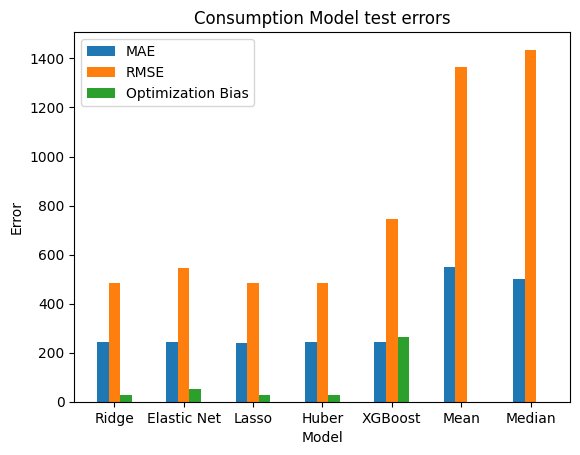

In [103]:
plt.bar(ind, final_cons_test_scores.T['MAE'], width, label='MAE')
plt.bar(ind + width, final_cons_test_scores.T['RMSE'], width, label='RMSE')
plt.bar(ind + 2 * width, final_cons_test_scores.T['RMSE'] - cv_rmse_scores['consumption'], width, label='Optimization Bias')

plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Consumption Model test errors')
plt.xticks(ind + width, final_cons_test_scores.columns)
plt.legend()

plt.show()

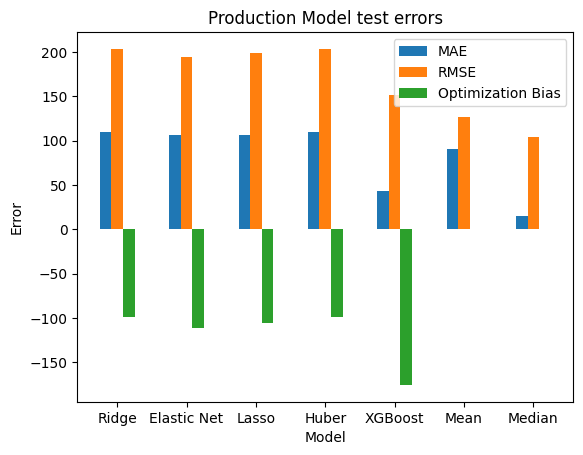

In [104]:
plt.bar(ind, final_prod_test_scores.T['MAE'], width, label='MAE')
plt.bar(ind + width, final_prod_test_scores.T['RMSE'], width, label='RMSE')
plt.bar(ind + 2 * width, final_prod_test_scores.T['RMSE'] - cv_rmse_scores['production'], width, label='Optimization Bias')

plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Production Model test errors')
plt.xticks(ind + width, final_prod_test_scores.columns)
plt.legend()

plt.show()